## Initializing the libraries

In [1]:
import os
import json

## Class to load data from the file and return the model accepected dataset

In [2]:
# Question answering dataloader class
class F21MPQADataLoader:
    # parameterized constructor received file name and the directory
    def __init__(self, fileName, directory) -> None:
        self.fileName = fileName
        self.directory = directory

    def get_dataset_filename(self) -> None:
        return self.fileName

    def get_dataset_directory(self) -> None:
        return self.directory

    def load_dataset_squad_format(self) -> None:
        # create dataset folder if not exists
        if not os.path.exists(self.directory):
            os.mkdir(self.directory)
        else:
            try:
                with open(os.path.join(self.directory, self.fileName), "rb") as f:
                    return self.__format_transformerbased_QAC(json.load(f))
            except Exception as e:
                print("Oops!", e.__class__, "occurred.")
            finally:
                f.close()

    def __format_transformerbased_QAC(self, jsonData) -> None:
        # initialize list where we will place all of our data
        new_squad = []
        # we need to loop through groups -> paragraphs -> qa_pairs
        for group in jsonData["data"]:
            for paragraph in group["paragraphs"]:
                # we pull out the context from here
                context = paragraph["context"]
                for qa_pair in paragraph["qas"]:
                    # we pull out the question
                    question = qa_pair["question"]
                    # now the logic to check if we have 'answers' or 'plausible_answers'
                    if "answers" in qa_pair.keys() and len(qa_pair["answers"]) > 0:
                        answer = qa_pair["answers"][0]["text"]
                    else:
                        # this shouldn't happen, but just in case we just set answer = None
                        answer = None
                    # append dictionary sample to parsed squad
                    new_squad.append(
                        {"question": question, "answer": answer, "context": context}
                    )
        return new_squad

In [3]:
train= F21MPQADataLoader('f21mp_test.json','data/f21mp');
train=train.load_dataset_squad_format()

## Model 

In [7]:
train[0]

{'question': 'How long it will take for express laundry?',
 'answer': '5 hours',
 'context': 'Our Express laundry service will return your items within 5 hours. Each item is subject to 50% additional charge.'}

In [25]:
from tqdm.auto import tqdm  # for our loading bar

text_data = []
file_count = 0

for sample in tqdm(train):
    if sample['context'] not in text_data:
        text_data.append(sample['context'].replace('\n', ''))
    if len(text_data) == 5_000:
            # once we hit the 5K mark, save to file
            with open(f'data/hospitality/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
                fp.write('\n'.join(text_data))
            text_data = []
            file_count += 1
    # after saving in 5K chunks, we will have ~3808 leftover samples, we save those now too
    with open(f'data/hospitality/text_{file_count}.txt', 'w', encoding='utf-8') as fp:
        fp.write('\n'.join(text_data))

 

100%|██████████| 91/91 [00:00<00:00, 2166.74it/s]


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizerFast


In [38]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [39]:
random_num = np.random.randint(0,len(train))


question = train[random_num]['question']
text = train[random_num]['context']

In [40]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 47 tokens.


In [41]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):
    print('{:8}{:8,}'.format(token,id))

[CLS]        101
where      2,073
is         2,003
the        1,996
mundo     25,989
restaurant   4,825
located    2,284
?          1,029
[SEP]        102
buffet    28,305
breakfast   6,350
is         2,003
served     2,366
in         1,999
mundo     25,989
located    2,284
in         1,999
the        1,996
lobby      9,568
level      2,504
(          1,006
ul        17,359
)          1,007
daily      3,679
from       2,013
6          1,020
##am       3,286
till       6,229
11         2,340
##am       3,286
during     2,076
weekdays  19,759
and        1,998
from       2,013
6          1,020
##am       3,286
till       6,229
11         2,340
:          1,024
30         2,382
##am       3,286
on         2,006
fridays   26,587
and        1,998
saturdays  18,860
.          1,012
[SEP]        102


In [43]:
#first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print(sep_idx)

#number of tokens in segment A - question
num_seg_a = sep_idx+1
print(num_seg_a)

#number of tokens in segment B - text
num_seg_b = len(input_ids) - num_seg_a
print(num_seg_b)

segment_ids = [0]*num_seg_a + [1]*num_seg_b
print(segment_ids)

assert len(segment_ids) == len(input_ids)

8
9
38
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [44]:
#token input_ids to represent the input
#token segment_ids to differentiate our segments - text and question 
output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
#print(output.start_logits, output.end_logits)

In [14]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
#print(answer_start, answer_end)

In [15]:
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")
    
print("Text:\n{}".format(text.capitalize()))
print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))

Text:
Kindly provide us your contact details including your e-mail address and our reservations team shall get back to you.alternatively, you may also reach them at +971 4 364 7555 or you may send an e-mail to reservations@abc.com.

Question:
What is the email to reach the reservations team for room booking?

Answer:
+ 97 ##1 4 36 ##4 75 ##55.


In [16]:
start_scores = output.start_logits.detach().numpy().flatten()
end_scores = output.end_logits.detach().numpy().flatten()

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

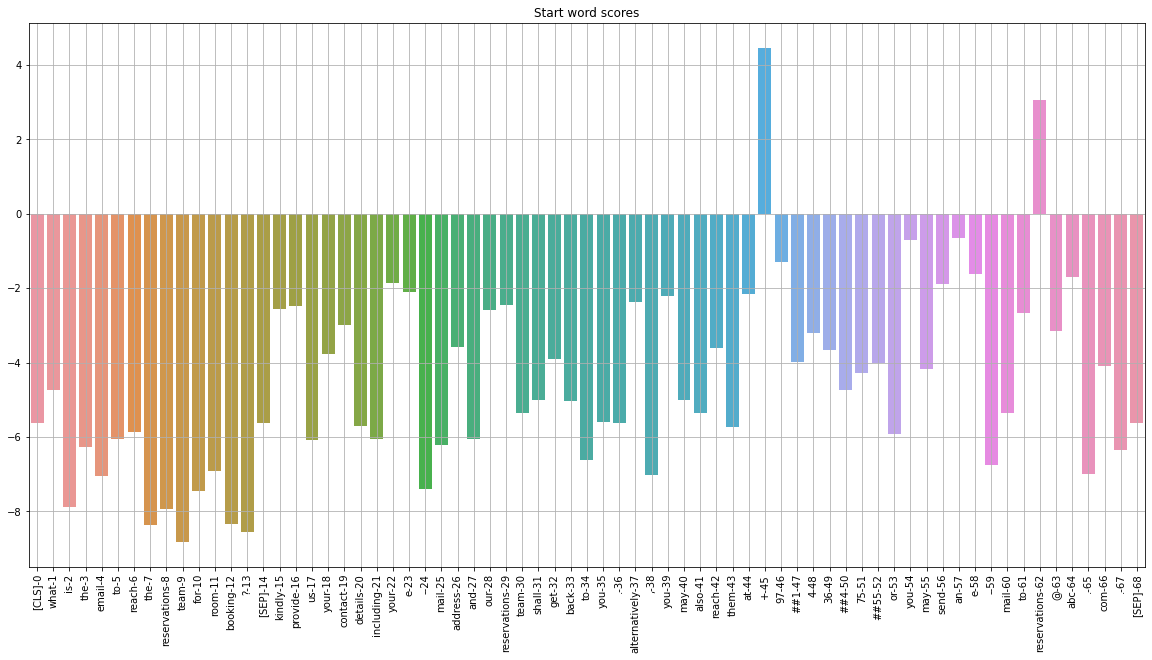

In [17]:

#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=start_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

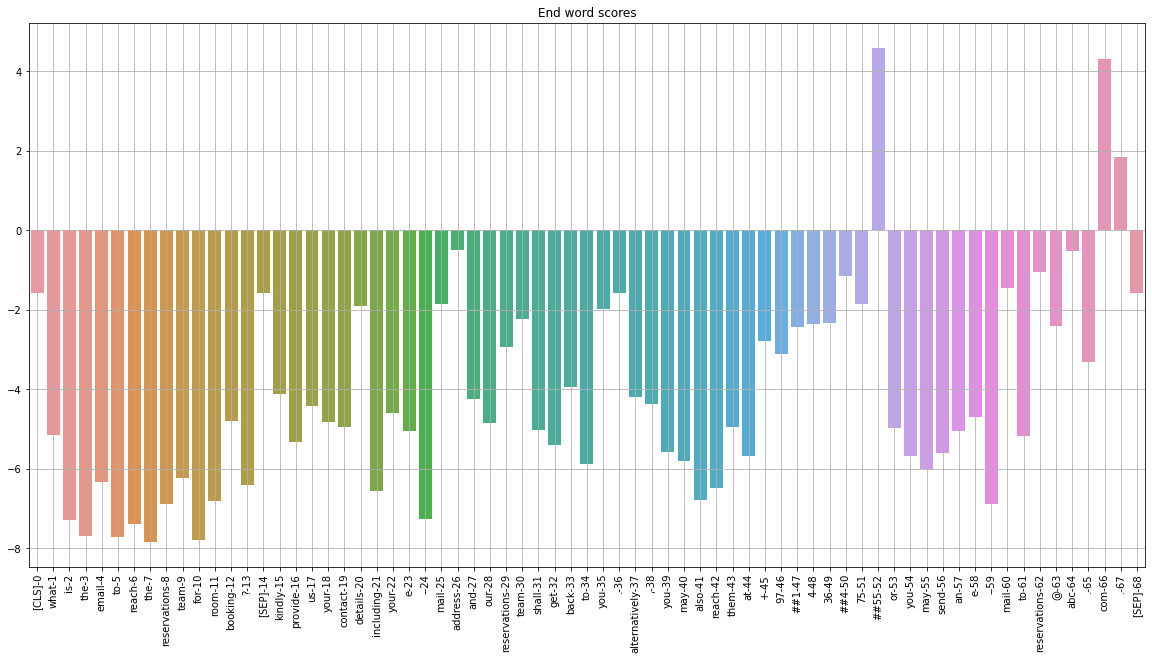

In [18]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=end_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

In [45]:
def question_answer(question, text):
    
    #tokenize question and text in ids as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    #number of tokens in segment A - question
    num_seg_a = sep_idx+1

    #number of tokens in segment B - text
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("<s>"):
        answer = "Unable to find the answer to your question."
    
#     print("Text:\n{}".format(text.capitalize()))
#     print("\nQuestion:\n{}".format(question.capitalize()))
    print("\nAnswer:\n{}".format(answer.capitalize()))

In [47]:
text = """Our express pressing service will deliver the collected items within an hour, Subject to a 50% additional charge."""
question = "Is there any additional charges applicable?"


question_answer(question, text)


Answer:
50 %


In [23]:
text = input("Please enter your text: \n")
question = input("\nPlease enter your question: \n")

while True:
    question_answer(question, text)
    
    flag = True
    flag_N = False
    
    while flag:
        response = input("\nDo you want to ask another question based on this text (Y/N)? ")
        if response[0] == "Y":
            question = input("\nPlease enter your question: \n")
            flag = False
        elif response[0] == "N":
            print("\nBye!")
            flag = False
            flag_N = True
            
    if flag_N == True:
        break


Answer:
Ijumeirah

Answer:
Open a web browser and click on the connect button .

Bye!
